In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [4]:
from sklearn.preprocessing import *
from sklearn.model_selection import *

In [5]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

In [6]:
df = pd.read_parquet('./parquet/preprocessed.parquet')

Drop unnecessary columns


In [7]:
df = df.drop(['ID', 'Dt_Customer', 'Kidhome', 'Teenhome'],
             axis=1).reset_index(drop=True)

In [8]:
columns = df.columns
columns_to_drop = [col for col in columns if col.startswith('Marital_')]
df = df.drop(columns=columns_to_drop)

## Modelling


In [9]:
from sklearn.svm import *
from sklearn.naive_bayes import *
from sklearn.tree import *
from sklearn.neighbors import *
from sklearn.linear_model import *

In [10]:
X = df.drop('Response', axis=1)
y = df.Response

pd.set_option('display.max_columns', 50)
X

,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Total_Children,Days_Since_Customer,Education_Basic,Education_Graduation,Education_Master,Education_PhD,A_Marital_Status_Married_Kidhome,A_Marital_Status_Married_Teenhome,A_Marital_Status_Single_Kidhome,A_Marital_Status_Single_Teenhome,A_Marital_Status_Together_Kidhome,A_Marital_Status_Together_Teenhome,A_Marital_Status_Widow_Kidhome,A_Marital_Status_Widow_Teenhome
0,1961,57091.0,0,464,5,64,7,0,37,1,7,3,7,5,0,0,3544,False,True,False,False,0,0,0,0,0,0,0,0
1,1958,67267.0,0,134,11,59,15,2,30,1,3,2,5,2,0,1,3577,False,True,False,False,0,1,0,0,0,0,0,0
2,1967,32474.0,0,10,0,1,0,0,0,1,1,0,2,7,0,2,3401,False,True,False,False,0,0,0,0,1,1,0,0
3,1989,21474.0,0,6,16,24,11,0,34,2,3,1,2,7,0,1,3494,False,True,False,False,0,0,1,0,0,0,0,0
4,1967,44931.0,0,78,0,11,0,0,7,1,2,1,3,5,0,1,3692,False,True,False,False,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,1974,20130.0,99,0,6,3,7,6,12,1,1,0,3,8,0,0,3634,False,False,False,False,0,0,0,0,0,0,0,0
1210,1973,42429.0,99,55,0,6,2,0,4,2,1,1,3,5,0,1,3404,False,True,False,False,0,0,0,0,0,0,0,1
1211,1973,42429.0,99,55,0,6,2,0,4,2,1,1,3,5,0,1,3404,False,True,False,False,0,0,0,0,0,0,0,1
1212,1977,31056.0,99,5,10,13,3,8,16,1,1,0,3,8,0,1,4053,False,False,False,False,1,0,0,0,0,0,0,0


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=12)

In [12]:
pf = PolynomialFeatures(interaction_only=True)
X_train = pf.fit_transform(X_train)
X_test = pf.transform(X_test)

In [13]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [14]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12)

In [15]:
def assess_cv(model, name):
    accuracy = cross_val_score(
        model, X_train, y_train, cv=skf, scoring='accuracy')
    precision = cross_val_score(
        model, X_train, y_train, cv=skf, scoring='precision')
    recall = cross_val_score(model, X_train, y_train, cv=skf, scoring='recall')
    f1 = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1')
    roc = cross_val_score(model, X_train, y_train, cv=skf, scoring='roc_auc')

    eval = {name: {} for n in range(5)}
    eval[name]['Accuracy'] = accuracy.mean()
    eval[name]['Precision'] = precision.mean()
    eval[name]['Recall'] = recall.mean()
    eval[name]['F1 Score'] = f1.mean()
    eval[name]['ROC AUC'] = roc.mean()
    return pd.DataFrame(eval).T

In [16]:
def eval(predictions):
    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, preds)
    print("Accuracy: %.4f" % acc)
    print("Precision: %.4f" % prec)
    print("Recall: %.4f" % rec)
    print("F1: %.4f" % f1)
    print("AUC: %.4f" % auc)

In [17]:
overview = pd.DataFrame({
    'Accuracy': [],
    'Precision': [],
    'Recall': [],
    'F1 Score': [],
    'ROC AUC': []
})

### Logistic Regression


In [18]:
params = {
    'max_iter': [50, 70, 100, 200, 500, 1000, 2000, 5000]
}

In [19]:
clf_lr = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=params,
    scoring='f1',
    cv=skf
)

In [20]:
clf_lr.fit(X_train, y_train)

d:\Programming Files\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Programming Files\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

d:\Programming Files\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'max_iter': [50, 70, 100, 200, 500, 1000, 2000, 5000]},
             scoring='f1')

In [21]:
clf_lr.best_estimator_

LogisticRegression(max_iter=50)

In [22]:
pd.DataFrame(clf_lr.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.039966,0.001544,0.002198,0.000393,50,{'max_iter': 50},0.368421,0.451613,0.500000,0.307692,0.432432,0.412032,0.067097,1
1,0.061928,0.004283,0.002396,0.000489,70,{'max_iter': 70},0.378378,0.400000,0.411765,0.296296,0.400000,0.377288,0.041907,8
2,0.062362,0.004381,0.002202,0.000396,100,{'max_iter': 100},0.388889,0.400000,0.411765,0.296296,0.400000,0.379390,0.042172,2
3,0.062683,0.004575,0.003001,0.001546,200,{'max_iter': 200},0.388889,0.400000,0.411765,0.296296,0.400000,0.379390,0.042172,2
4,0.061147,0.005285,0.001796,0.000398,500,{'max_iter': 500},0.388889,0.400000,0.411765,0.296296,0.400000,0.379390,0.042172,2
5,0.070250,0.009286,0.002216,0.000435,1000,{'max_iter': 1000},0.388889,0.400000,0.411765,0.296296,0.400000,0.379390,0.042172,2
6,0.057044,0.004652,0.001917,0.000178,2000,{'max_iter': 2000},0.388889,0.400000,0.411765,0.296296,0.400000,0.379390,0.042172,2
7,0.057348,0.002968,0.002197,0.000408,5000,{'max_iter': 5000},0.388889,0.400000,0.411765,0.296296,0.400000,0.379390,0.042172,2


In [23]:
print(pd.DataFrame(clf_lr.cv_results_)[
      ['param_max_iter', 'mean_test_score', 'rank_test_score']].to_latex(index=False))

\begin{tabular}{lrr}
\toprule
param_max_iter & mean_test_score & rank_test_score \\
\midrule
50 & 0.412032 & 1 \\
70 & 0.377288 & 8 \\
100 & 0.379390 & 2 \\
200 & 0.379390 & 2 \\
500 & 0.379390 & 2 \\
1000 & 0.379390 & 2 \\
2000 & 0.379390 & 2 \\
5000 & 0.379390 & 2 \\
\bottomrule
\end{tabular}



In [24]:
# scores = cross_val_score(clf_lr.best_estimator_, X_train, y_train, cv=skf, scoring='roc_auc')
assess_cv(clf_lr.best_estimator_, 'Logistic Regression')

d:\Programming Files\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Programming Files\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

,Accuracy,F1 Score,Precision,ROC AUC,Recall
Logistic Regression,0.899096,0.412032,0.461903,0.801161,0.388889


In [25]:
overview = pd.concat([overview, assess_cv(
    clf_lr.best_estimator_, 'Logistic Regression')])

d:\Programming Files\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Programming Files\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

### SVM


In [26]:
params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': ['scale', 'auto'],
}

In [27]:
clf_svc = GridSearchCV(
    estimator=SVC(),
    param_grid=params,
    scoring='f1',
    cv=skf
)

In [28]:
clf_svc.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12, shuffle=True),
             estimator=SVC(),
             param_grid={'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='f1')

In [29]:
clf_svc.best_estimator_

SVC(kernel='linear')

In [30]:
pd.DataFrame(clf_svc.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_gamma,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.033934,0.002554,0.003825,0.000417,scale,linear,"{'gamma': 'scale', 'kernel': 'linear'}",0.410256,0.432432,0.444444,0.294118,0.444444,0.405139,0.056898,1
1,0.019511,0.000442,0.005805,0.000390,scale,poly,"{'gamma': 'scale', 'kernel': 'poly'}",0.086957,0.000000,0.076923,0.000000,0.090909,0.050958,0.041856,4
2,0.025804,0.002382,0.011612,0.000482,scale,rbf,"{'gamma': 'scale', 'kernel': 'rbf'}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5
3,0.017633,0.001415,0.004804,0.000390,scale,sigmoid,"{'gamma': 'scale', 'kernel': 'sigmoid'}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5
4,0.034722,0.003707,0.004006,0.000020,auto,linear,"{'gamma': 'auto', 'kernel': 'linear'}",0.410256,0.432432,0.444444,0.294118,0.444444,0.405139,0.056898,1
5,0.018836,0.000809,0.005401,0.000490,auto,poly,"{'gamma': 'auto', 'kernel': 'poly'}",0.086957,0.000000,0.083333,0.000000,0.090909,0.052240,0.042721,3
6,0.022109,0.005232,0.012002,0.000638,auto,rbf,"{'gamma': 'auto', 'kernel': 'rbf'}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5
7,0.017513,0.002011,0.004487,0.000449,auto,sigmoid,"{'gamma': 'auto', 'kernel': 'sigmoid'}",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5


In [31]:
print(pd.DataFrame(clf_svc.cv_results_)[
      ['param_gamma', 'param_kernel', 'mean_test_score', 'rank_test_score']].to_latex(index=False))

\begin{tabular}{llrr}
\toprule
param_gamma & param_kernel & mean_test_score & rank_test_score \\
\midrule
scale & linear & 0.405139 & 1 \\
scale & poly & 0.050958 & 4 \\
scale & rbf & 0.000000 & 5 \\
scale & sigmoid & 0.000000 & 5 \\
auto & linear & 0.405139 & 1 \\
auto & poly & 0.052240 & 3 \\
auto & rbf & 0.000000 & 5 \\
auto & sigmoid & 0.000000 & 5 \\
\bottomrule
\end{tabular}



In [32]:
# scores = cross_val_score(clf_svc.best_estimator_, X_train, y_train, cv=skf, scoring='precision')
assess_cv(clf_svc.best_estimator_, 'SVM')

,Accuracy,F1 Score,Precision,ROC AUC,Recall
SVM,0.888781,0.405139,0.400679,0.770827,0.411111


In [33]:
overview = pd.concat([overview, assess_cv(clf_svc.best_estimator_, 'SVM')])

### Naive Bayes


In [34]:
params = {
    'alpha': [1.0, 2.0, 5.0, 7, 10],
    'fit_prior': [True, False],
}

In [35]:
clf_nb = GridSearchCV(
    estimator=BernoulliNB(),
    param_grid=params,
    scoring='f1',
    cv=skf
)

In [36]:
clf_nb.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12, shuffle=True),
             estimator=BernoulliNB(),
             param_grid={'alpha': [1.0, 2.0, 5.0, 7, 10],
                         'fit_prior': [True, False]},
             scoring='f1')

In [37]:
clf_nb.best_estimator_

BernoulliNB(alpha=2.0)

In [38]:
pd.DataFrame(clf_nb.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_fit_prior,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006506,0.000445,0.003002,0.000007,1.0,True,"{'alpha': 1.0, 'fit_prior': True}",0.250000,0.339623,0.309859,0.350877,0.278481,0.305768,0.037556,3
1,0.006399,0.000490,0.003203,0.000397,1.0,False,"{'alpha': 1.0, 'fit_prior': False}",0.263158,0.354839,0.285714,0.323529,0.318182,0.309084,0.031750,2
2,0.005888,0.000476,0.002996,0.000019,2.0,True,"{'alpha': 2.0, 'fit_prior': True}",0.257143,0.333333,0.333333,0.344828,0.285714,0.310870,0.033710,1
3,0.006398,0.000800,0.002215,0.000392,2.0,False,"{'alpha': 2.0, 'fit_prior': False}",0.240000,0.338983,0.297297,0.322581,0.285714,0.296915,0.034039,4
4,0.005608,0.000469,0.002999,0.000634,5.0,True,"{'alpha': 5.0, 'fit_prior': True}",0.241379,0.250000,0.305085,0.226415,0.297297,0.264035,0.031359,6
5,0.006514,0.000446,0.002794,0.000404,5.0,False,"{'alpha': 5.0, 'fit_prior': False}",0.208955,0.296296,0.307692,0.237288,0.311688,0.272384,0.041517,5
6,0.006011,0.000021,0.003001,0.000011,7,True,"{'alpha': 7, 'fit_prior': True}",0.222222,0.232558,0.301887,0.244898,0.307692,0.261851,0.035834,7
7,0.005796,0.000740,0.002802,0.000395,7,False,"{'alpha': 7, 'fit_prior': False}",0.203390,0.244898,0.295082,0.222222,0.281690,0.249456,0.034656,8
8,0.006994,0.000623,0.002813,0.000396,10,True,"{'alpha': 10, 'fit_prior': True}",0.222222,0.205128,0.250000,0.255319,0.310345,0.248603,0.035903,10
9,0.005988,0.000632,0.003104,0.000196,10,False,"{'alpha': 10, 'fit_prior': False}",0.188679,0.238095,0.269231,0.250000,0.300000,0.249201,0.036793,9


In [39]:
print(pd.DataFrame(clf_nb.cv_results_)[
      ['param_alpha', 'param_fit_prior', 'mean_test_score', 'rank_test_score']].to_latex(index=False))

\begin{tabular}{llrr}
\toprule
param_alpha & param_fit_prior & mean_test_score & rank_test_score \\
\midrule
1.000000 & True & 0.305768 & 3 \\
1.000000 & False & 0.309084 & 2 \\
2.000000 & True & 0.310870 & 1 \\
2.000000 & False & 0.296915 & 4 \\
5.000000 & True & 0.264035 & 6 \\
5.000000 & False & 0.272384 & 5 \\
7 & True & 0.261851 & 7 \\
7 & False & 0.249456 & 8 \\
10 & True & 0.248603 & 10 \\
10 & False & 0.249201 & 9 \\
\bottomrule
\end{tabular}



In [40]:
# scores = cross_val_score(clf_nb, X_train, y_train, cv=skf, scoring='f1')
assess_cv(clf_nb.best_estimator_, 'Naive Bayes')

,Accuracy,F1 Score,Precision,ROC AUC,Recall
Naive Bayes,0.768316,0.31087,0.217737,0.760116,0.555556


In [41]:
tt = pd.concat([assess_cv(clf_nb.best_estimator_, 'Bernoulli NB'),
               assess_cv(GaussianNB(), 'Gaussian NB')])

In [42]:
print(tt.to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & Accuracy & F1 Score & Precision & ROC AUC & Recall \\
\midrule
Bernoulli NB & 0.768316 & 0.310870 & 0.217737 & 0.760116 & 0.555556 \\
Gaussian NB & 0.244092 & 0.176973 & 0.098413 & 0.530368 & 0.877778 \\
\bottomrule
\end{tabular}



In [43]:
tt

,Accuracy,F1 Score,Precision,ROC AUC,Recall
Bernoulli NB,0.768316,0.310870,0.217737,0.760116,0.555556
Gaussian NB,0.244092,0.176973,0.098413,0.530368,0.877778


In [44]:
overview = pd.concat([overview, assess_cv(clf_nb, 'Naive Bayes')])

### Decision Tree


In [45]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'splitter': ['best', 'random'],
    'min_samples_split': [2, 5, 10]
}

In [46]:
clf_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(),
    param_grid=params,
    scoring='f1',
    cv=skf
)

In [47]:

clf_dt.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'min_samples_split': [2, 5, 10],
                         'splitter': ['best', 'random']},
             scoring='f1')

In [48]:
clf_dt.best_estimator_

DecisionTreeClassifier(criterion='log_loss')

In [49]:
pd.DataFrame(clf_dt.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_min_samples_split,param_splitter,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.075628,0.008262,0.002209,0.000750,gini,2,best,"{'criterion': 'gini', 'min_samples_split': 2, ...",0.341463,0.529412,0.307692,0.432432,0.473684,0.416937,0.082148,4
1,0.014875,0.001376,0.002214,0.000399,gini,2,random,"{'criterion': 'gini', 'min_samples_split': 2, ...",0.315789,0.360000,0.352941,0.424242,0.322581,0.355111,0.038502,16
2,0.071100,0.008834,0.001994,0.000627,gini,5,best,"{'criterion': 'gini', 'min_samples_split': 5, ...",0.341463,0.432432,0.250000,0.400000,0.352941,0.355367,0.062020,15
3,0.013601,0.000796,0.002002,0.000634,gini,5,random,"{'criterion': 'gini', 'min_samples_split': 5, ...",0.228571,0.410256,0.358974,0.363636,0.294118,0.331111,0.063216,17
4,0.070546,0.008052,0.002402,0.000806,gini,10,best,"{'criterion': 'gini', 'min_samples_split': 10,...",0.325581,0.432432,0.418605,0.413793,0.375000,0.393082,0.038761,8
5,0.013394,0.001743,0.001833,0.000416,gini,10,random,"{'criterion': 'gini', 'min_samples_split': 10,...",0.324324,0.388889,0.307692,0.312500,0.303030,0.327287,0.031606,18
6,0.055011,0.002484,0.002105,0.000670,entropy,2,best,"{'criterion': 'entropy', 'min_samples_split': ...",0.470588,0.540541,0.372093,0.400000,0.388889,0.434422,0.062789,2
7,0.012910,0.001278,0.002203,0.000751,entropy,2,random,"{'criterion': 'entropy', 'min_samples_split': ...",0.341463,0.342857,0.512821,0.352941,0.358974,0.381811,0.065824,11
8,0.054754,0.002947,0.001803,0.000392,entropy,5,best,"{'criterion': 'entropy', 'min_samples_split': ...",0.375000,0.540541,0.324324,0.363636,0.388889,0.398478,0.074213,6
9,0.012491,0.000441,0.002011,0.000004,entropy,5,random,"{'criterion': 'entropy', 'min_samples_split': ...",0.312500,0.526316,0.536585,0.266667,0.324324,0.393278,0.114496,7


In [50]:
print(pd.DataFrame(clf_dt.cv_results_)[['param_criterion', 'param_min_samples_split',
      'param_splitter', 'mean_test_score', 'rank_test_score']].to_latex(index=False))

\begin{tabular}{lllrr}
\toprule
param_criterion & param_min_samples_split & param_splitter & mean_test_score & rank_test_score \\
\midrule
gini & 2 & best & 0.416937 & 4 \\
gini & 2 & random & 0.355111 & 16 \\
gini & 5 & best & 0.355367 & 15 \\
gini & 5 & random & 0.331111 & 17 \\
gini & 10 & best & 0.393082 & 8 \\
gini & 10 & random & 0.327287 & 18 \\
entropy & 2 & best & 0.434422 & 2 \\
entropy & 2 & random & 0.381811 & 11 \\
entropy & 5 & best & 0.398478 & 6 \\
entropy & 5 & random & 0.393278 & 7 \\
entropy & 10 & best & 0.400618 & 5 \\
entropy & 10 & random & 0.373798 & 12 \\
log_loss & 2 & best & 0.441948 & 1 \\
log_loss & 2 & random & 0.366357 & 13 \\
log_loss & 5 & best & 0.423310 & 3 \\
log_loss & 5 & random & 0.359315 & 14 \\
log_loss & 10 & best & 0.387211 & 9 \\
log_loss & 10 & random & 0.386008 & 10 \\
\bottomrule
\end{tabular}



In [51]:
assess_cv(clf_dt.best_estimator_, 'Decision Tree')

,Accuracy,F1 Score,Precision,ROC AUC,Recall
Decision Tree,0.894946,0.427286,0.404132,0.689269,0.433333


In [52]:
overview = pd.concat([overview, assess_cv(
    clf_dt.best_estimator_, 'Decision Tree')])

### K-Nearest Neighbors


In [53]:
params = {
    'n_neighbors': [1, 2, 5, 7, 10],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

In [54]:
clf_kn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=params,
    scoring='f1',
    cv=skf
)

In [55]:
clf_kn.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=12, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
                         'n_neighbors': [1, 2, 5, 7, 10],
                         'weights': ['uniform', 'distance']},
             scoring='f1')

In [56]:
clf_kn.best_estimator_

KNeighborsClassifier(n_neighbors=1)

In [57]:
pd.DataFrame(clf_kn.cv_results_).sort_values(by='rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_algorithm,param_n_neighbors,param_weights,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.002003,0.000001,0.048224,0.073704,auto,1,uniform,"{'algorithm': 'auto', 'n_neighbors': 1, 'weigh...",0.235294,0.410256,0.270270,0.307692,0.375000,0.319703,0.064762,1
11,0.011999,0.000632,0.054328,0.001436,ball_tree,1,distance,"{'algorithm': 'ball_tree', 'n_neighbors': 1, '...",0.235294,0.410256,0.270270,0.307692,0.375000,0.319703,0.064762,1
30,0.001605,0.000494,0.010394,0.000493,brute,1,uniform,"{'algorithm': 'brute', 'n_neighbors': 1, 'weig...",0.235294,0.410256,0.270270,0.307692,0.375000,0.319703,0.064762,1
31,0.001800,0.000402,0.009903,0.000802,brute,1,distance,"{'algorithm': 'brute', 'n_neighbors': 1, 'weig...",0.235294,0.410256,0.270270,0.307692,0.375000,0.319703,0.064762,1
10,0.013305,0.002090,0.060728,0.002272,ball_tree,1,uniform,"{'algorithm': 'ball_tree', 'n_neighbors': 1, '...",0.235294,0.410256,0.270270,0.307692,0.375000,0.319703,0.064762,1
1,0.002608,0.000495,0.010699,0.000750,auto,1,distance,"{'algorithm': 'auto', 'n_neighbors': 1, 'weigh...",0.235294,0.410256,0.270270,0.307692,0.375000,0.319703,0.064762,1
21,0.020403,0.000803,0.062453,0.001559,kd_tree,1,distance,"{'algorithm': 'kd_tree', 'n_neighbors': 1, 'we...",0.235294,0.410256,0.270270,0.307692,0.363636,0.317430,0.062955,7
20,0.020212,0.000521,0.068842,0.001828,kd_tree,1,uniform,"{'algorithm': 'kd_tree', 'n_neighbors': 1, 'we...",0.235294,0.410256,0.270270,0.307692,0.363636,0.317430,0.062955,7
33,0.001405,0.000492,0.010792,0.000739,brute,2,distance,"{'algorithm': 'brute', 'n_neighbors': 2, 'weig...",0.235294,0.368421,0.277778,0.307692,0.375000,0.312837,0.053334,9
3,0.003002,0.000004,0.016714,0.003331,auto,2,distance,"{'algorithm': 'auto', 'n_neighbors': 2, 'weigh...",0.235294,0.368421,0.277778,0.307692,0.375000,0.312837,0.053334,9


In [58]:
print(pd.DataFrame(clf_kn.cv_results_).sort_values(by='rank_test_score')[
      ['param_algorithm', 'param_n_neighbors', 'param_weights', 'mean_test_score', 'rank_test_score']].to_latex(index=False))

\begin{tabular}{lllrr}
\toprule
param_algorithm & param_n_neighbors & param_weights & mean_test_score & rank_test_score \\
\midrule
auto & 1 & uniform & 0.319703 & 1 \\
ball_tree & 1 & distance & 0.319703 & 1 \\
brute & 1 & uniform & 0.319703 & 1 \\
brute & 1 & distance & 0.319703 & 1 \\
ball_tree & 1 & uniform & 0.319703 & 1 \\
auto & 1 & distance & 0.319703 & 1 \\
kd_tree & 1 & distance & 0.317430 & 7 \\
kd_tree & 1 & uniform & 0.317430 & 7 \\
brute & 2 & distance & 0.312837 & 9 \\
auto & 2 & distance & 0.312837 & 9 \\
ball_tree & 2 & distance & 0.312837 & 9 \\
kd_tree & 2 & distance & 0.312837 & 9 \\
auto & 7 & distance & 0.231143 & 13 \\
brute & 7 & distance & 0.231143 & 13 \\
kd_tree & 7 & distance & 0.231143 & 13 \\
ball_tree & 7 & distance & 0.231143 & 13 \\
auto & 5 & distance & 0.223317 & 17 \\
ball_tree & 5 & distance & 0.223317 & 17 \\
kd_tree & 5 & distance & 0.223317 & 17 \\
brute & 5 & distance & 0.223317 & 17 \\
kd_tree & 10 & distance & 0.200369 & 21 \\
ball_tree & 10 &

In [59]:
assess_cv(clf_kn.best_estimator_, 'K-Nearest Neighbors')

,Accuracy,F1 Score,Precision,ROC AUC,Recall
K-Nearest Neighbors,0.882612,0.319703,0.364536,0.621061,0.3


In [60]:
overview = pd.concat([overview, assess_cv(
    clf_kn.best_estimator_, 'K-Nearest Neighbors')])

In [61]:
overview

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Logistic Regression,0.899096,0.461903,0.388889,0.412032,0.801161
SVM,0.888781,0.400679,0.411111,0.405139,0.770827
Naive Bayes,0.761121,0.205177,0.533333,0.294140,0.759150
Decision Tree,0.888760,0.431638,0.355556,0.416177,0.707015
K-Nearest Neighbors,0.882612,0.364536,0.300000,0.319703,0.621061


In [62]:
overview.T

,Logistic Regression,SVM,Naive Bayes,Decision Tree,K-Nearest Neighbors
Accuracy,0.899096,0.888781,0.761121,0.888760,0.882612
Precision,0.461903,0.400679,0.205177,0.431638,0.364536
Recall,0.388889,0.411111,0.533333,0.355556,0.300000
F1 Score,0.412032,0.405139,0.294140,0.416177,0.319703
ROC AUC,0.801161,0.770827,0.759150,0.707015,0.621061


In [63]:
print(overview.to_latex())

\begin{tabular}{lrrrrr}
\toprule
 & Accuracy & Precision & Recall & F1 Score & ROC AUC \\
\midrule
Logistic Regression & 0.899096 & 0.461903 & 0.388889 & 0.412032 & 0.801161 \\
SVM & 0.888781 & 0.400679 & 0.411111 & 0.405139 & 0.770827 \\
Naive Bayes & 0.761121 & 0.205177 & 0.533333 & 0.294140 & 0.759150 \\
Decision Tree & 0.888760 & 0.431638 & 0.355556 & 0.416177 & 0.707015 \\
K-Nearest Neighbors & 0.882612 & 0.364536 & 0.300000 & 0.319703 & 0.621061 \\
\bottomrule
\end{tabular}



## Evaluation


### Logistic Regression


In [64]:
pd.DataFrame(pf.get_feature_names_out()).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,...,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435
0,1,Year_Birth,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Complain,Total_Children,Days_Since_Customer,Education_Basic,Education_Graduation,Education_Master,Education_PhD,A_Marital_Status_Married_Kidhome,A_Marital_Status_Married_Teenhome,A_Marital_Status_Single_Kidhome,...,A_Marital_Status_Married_Kidhome A_Marital_Sta...,A_Marital_Status_Married_Kidhome A_Marital_Sta...,A_Marital_Status_Married_Kidhome A_Marital_Sta...,A_Marital_Status_Married_Kidhome A_Marital_Sta...,A_Marital_Status_Married_Teenhome A_Marital_St...,A_Marital_Status_Married_Teenhome A_Marital_St...,A_Marital_Status_Married_Teenhome A_Marital_St...,A_Marital_Status_Married_Teenhome A_Marital_St...,A_Marital_Status_Married_Teenhome A_Marital_St...,A_Marital_Status_Married_Teenhome A_Marital_St...,A_Marital_Status_Single_Kidhome A_Marital_Stat...,A_Marital_Status_Single_Kidhome A_Marital_Stat...,A_Marital_Status_Single_Kidhome A_Marital_Stat...,A_Marital_Status_Single_Kidhome A_Marital_Stat...,A_Marital_Status_Single_Kidhome A_Marital_Stat...,A_Marital_Status_Single_Teenhome A_Marital_Sta...,A_Marital_Status_Single_Teenhome A_Marital_Sta...,A_Marital_Status_Single_Teenhome A_Marital_Sta...,A_Marital_Status_Single_Teenhome A_Marital_Sta...,A_Marital_Status_Together_Kidhome A_Marital_St...,A_Marital_Status_Together_Kidhome A_Marital_St...,A_Marital_Status_Together_Kidhome A_Marital_St...,A_Marital_Status_Together_Teenhome A_Marital_S...,A_Marital_Status_Together_Teenhome A_Marital_S...,A_Marital_Status_Widow_Kidhome A_Marital_Statu...


In [65]:
lr = clf_lr.best_estimator_

In [66]:
coefficients = pd.DataFrame(data=lr.coef_, columns=pf.get_feature_names_out())

In [67]:
top5 = coefficients.loc[0].sort_values(ascending=False).iloc[:5]

In [68]:
pd.DataFrame(data=top5.values, index=top5.index)

,0
MntFruits A_Marital_Status_Single_Kidhome,0.964310
MntMeatProducts A_Marital_Status_Married_Teenhome,0.909317
MntWines A_Marital_Status_Together_Teenhome,0.904126
MntWines NumWebPurchases,0.851960
Education_Master A_Marital_Status_Single_Kidhome,0.772630


### SVM


In [69]:
svm = clf_svc.best_estimator_

In [70]:
coefficients = pd.DataFrame(data=svm.coef_, columns=pf.get_feature_names_out())

In [71]:
top5 = coefficients.loc[0].sort_values(ascending=False).iloc[:5]

In [72]:
pd.DataFrame(top5)

,0
MntWines NumWebPurchases,0.904773
A_Marital_Status_Married_Kidhome A_Marital_Status_Married_Teenhome,0.804857
MntFruits A_Marital_Status_Single_Kidhome,0.803837
NumWebVisitsMonth A_Marital_Status_Single_Kidhome,0.769760
Recency Days_Since_Customer,0.733147


In [73]:
print(pd.DataFrame(top5).to_latex())

\begin{tabular}{lr}
\toprule
 & 0 \\
\midrule
MntWines NumWebPurchases & 0.904773 \\
A_Marital_Status_Married_Kidhome A_Marital_Status_Married_Teenhome & 0.804857 \\
MntFruits A_Marital_Status_Single_Kidhome & 0.803837 \\
NumWebVisitsMonth A_Marital_Status_Single_Kidhome & 0.769760 \\
Recency Days_Since_Customer & 0.733147 \\
\bottomrule
\end{tabular}



In [74]:
svecs = pd.DataFrame(sc.inverse_transform(
    svm.support_vectors_), columns=pf.get_feature_names_out())

In [75]:
print(svecs.mean())

1                                                                         1.000000
Year_Birth                                                             1970.030303
Income                                                                37390.267677
Recency                                                                  30.606061
MntWines                                                                101.590909
                                                                          ...     
A_Marital_Status_Together_Kidhome A_Marital_Status_Widow_Kidhome          0.000000
A_Marital_Status_Together_Kidhome A_Marital_Status_Widow_Teenhome         0.000000
A_Marital_Status_Together_Teenhome A_Marital_Status_Widow_Kidhome         0.000000
A_Marital_Status_Together_Teenhome A_Marital_Status_Widow_Teenhome        0.000000
A_Marital_Status_Widow_Kidhome A_Marital_Status_Widow_Teenhome            0.015152
Length: 436, dtype: float64


In [76]:
X_train.shape

(971, 436)

In [77]:
svecs.shape

(198, 436)

In [78]:
svm.n_support_

array([131,  67])

In [79]:
198/971

0.203913491246138

### Naive Bayes


In [80]:
nb = clf_nb.best_estimator_

In [81]:
df.value_counts('Response')

Response
0    1101
1     113
Name: count, dtype: int64

In [82]:
nb.class_log_prior_

array([-0.09726884, -2.3785168 ])

In [83]:
flp = pd.DataFrame(nb.feature_log_prob_, columns=pf.get_feature_names_out())

In [84]:
print(pd.DataFrame(flp.loc[0].sort_values(
    ascending=False).iloc[:5]).to_latex())

\begin{tabular}{lr}
\toprule
 & 0 \\
\midrule
Year_Birth & -0.624380 \\
Year_Birth Recency & -0.641402 \\
NumCatalogPurchases Days_Since_Customer & -0.650023 \\
NumCatalogPurchases & -0.650023 \\
Recency & -0.650023 \\
\bottomrule
\end{tabular}



## Decision Trees


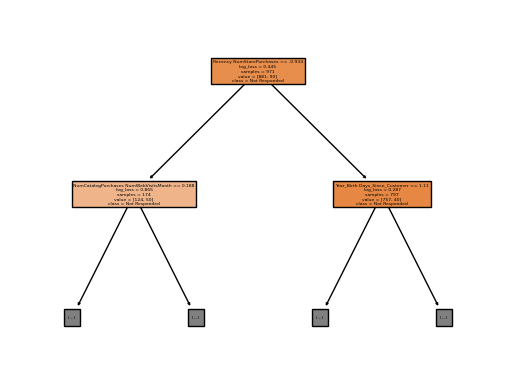

In [85]:
from sklearn.tree import plot_tree

plot_tree(clf_dt.best_estimator_, filled=True, feature_names=pf.get_feature_names_out(
), class_names=['Not Responded', 'Responded'], max_depth=1)
plt.show()

## K-Nearest Neighbors


## Confusion Matrices


#### Logistic Regression


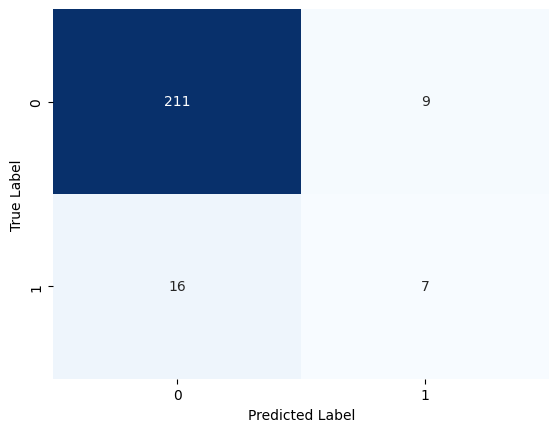

In [106]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

lr_preds = clf_lr.best_estimator_.predict(X_test)

lr_cm = confusion_matrix(y_test, lr_preds)

categories = ['True Negative', 'False Positive',
              'False Negative', 'True Positive']

sns.heatmap(lr_cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### SVM


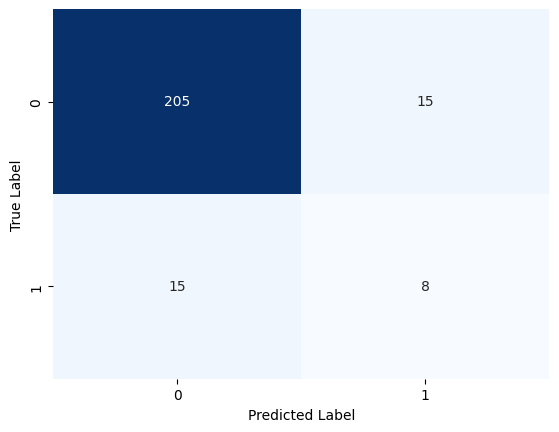

In [105]:
svm_preds = clf_svc.best_estimator_.predict(X_test)

svm_cm = confusion_matrix(y_test, svm_preds)

sns.heatmap(svm_cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Naive Bayes


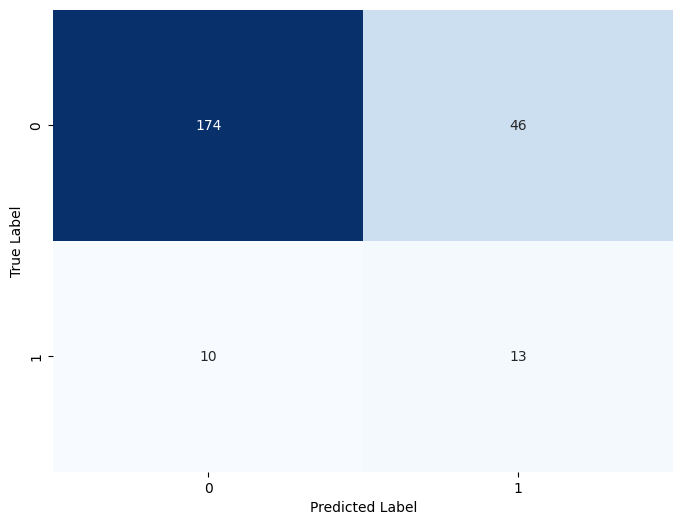

In [104]:
nb_preds = clf_nb.best_estimator_.predict(X_test)

nb_cm = confusion_matrix(y_test, nb_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(nb_cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Decision Trees


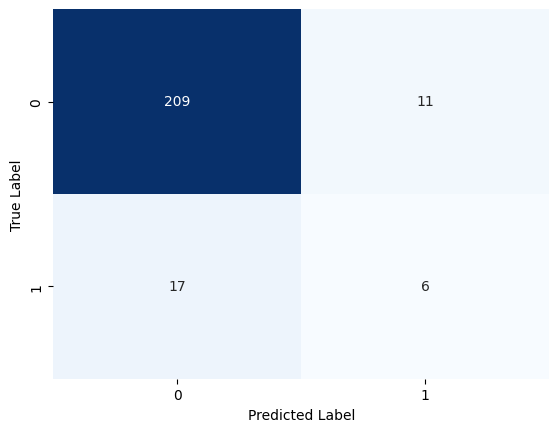

In [103]:
dt_preds = clf_dt.best_estimator_.predict(X_test)

dt_cm = confusion_matrix(y_test, dt_preds)

sns.heatmap(dt_cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### K-Nearest Neighbors


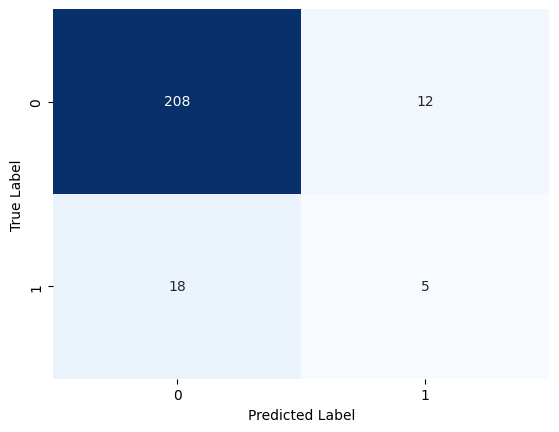

In [102]:
kn_preds = clf_kn.best_estimator_.predict(X_test)

kn_cm = confusion_matrix(y_test, kn_preds)

sns.heatmap(kn_cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()